## Data Profiling

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser  # for parse_date_safe

# 1) Load your CSV (change path as needed)
df = pd.read_csv("../data/raw_analyst_ratings.csv")


# Optional: nicer display
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 4)

df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
def parse_date_safe(x):
    """
    Safely parse a date string into a pandas Timestamp.
    Returns NaT if parsing fails.
    """
    x = str(x).strip()
    
    # 1. Try general parser (handles ISO + timezone)
    try:
        return parser.parse(x)
    except Exception:
        pass
    
    # 2. Try explicit US format with time (e.g. 05/22/2020 11:23)
    try:
        return pd.to_datetime(x, format="%m/%d/%Y %H:%M")
    except Exception:
        pass
    
    # 3. Try US format without time (e.g. 05/22/2020)
    try:
        return pd.to_datetime(x, format="%m/%d/%Y")
    except Exception:
        pass
    
    # If everything fails:
    return pd.NaT

# Apply the parser
df["date"] = df["date"].apply(parse_date_safe)

# If the dtype is timezone-aware, drop the timezone
if pd.api.types.is_datetime64tz_dtype(df["date"]):
    df["date"] = df["date"].dt.tz_localize(None)

df["date"].head()


C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_33464\930441296.py:33: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df["date"]):


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

In [6]:
# Ensure the 'date' column is converted to datetimes and made timezone-naive
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
if pd.api.types.is_datetime64tz_dtype(df['date']):
	df['date'] = df['date'].dt.tz_localize(None)

print("Start date:", df['date'].min())
print("End date:", df['date'].max())

Start date: 2009-02-14 00:00:00
End date: 2020-06-11 21:12:35


C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_33464\2400426716.py:3: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['date']):


In [7]:
# 1) Headline length (characters)
df["headline_len"] = df["headline"].astype(str).str.len()

# 2) Date-only (no time) for daily counts
df["date_only"] = df["date"].dt.date

# 3) Day name (Monday, Tuesday, etc.)
df["weekday"] = df["date"].dt.day_name()

df[["headline", "headline_len", "date", "date_only", "weekday"]].head()


,headline,headline_len,date,date_only,weekday
0,Stocks That Hit 52-Week Highs On Friday,39,2020-06-05 14:30:54,2020-06-05,Friday
1,Stocks That Hit 52-Week Highs On Wednesday,42,2020-06-03 14:45:20,2020-06-03,Wednesday
2,71 Biggest Movers From Friday,29,2020-05-26 08:30:07,2020-05-26,Tuesday
3,46 Stocks Moving In Friday's Mid-Day Session,44,2020-05-22 16:45:06,2020-05-22,Friday
4,B of A Securities Maintains Neutral on Agilent...,87,2020-05-22 15:38:59,2020-05-22,Friday


## EDA 

Headline length statistics

In [8]:
headline_stats = df["headline_len"].describe()
headline_stats


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64

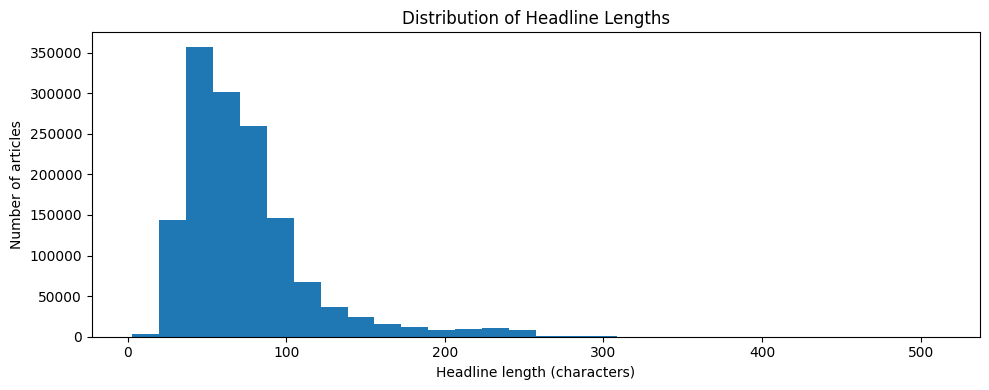

In [9]:
plt.figure()
plt.hist(df["headline_len"], bins=30)
plt.xlabel("Headline length (characters)")
plt.ylabel("Number of articles")
plt.title("Distribution of Headline Lengths")
plt.tight_layout()
plt.show()


Number of articles per publisher

Counts per publisher

In [10]:
publisher_counts = df["publisher"].value_counts()
publisher_counts.head(10)


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

Bar chart of most active publishers

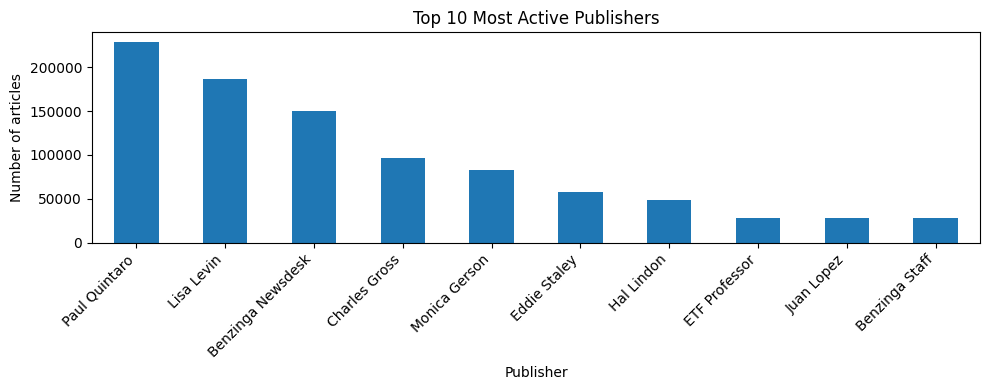

In [11]:
top_n = 10  # change if you want more/less
plt.figure()
publisher_counts.head(top_n).plot(kind="bar")
plt.xlabel("Publisher")
plt.ylabel("Number of articles")
plt.title(f"Top {top_n} Most Active Publishers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Publication dates – trends over time

In [ ]:
articles_per_day = df.groupby("date_only").size()

articles_per_day.head()



date_only
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
dtype: int64

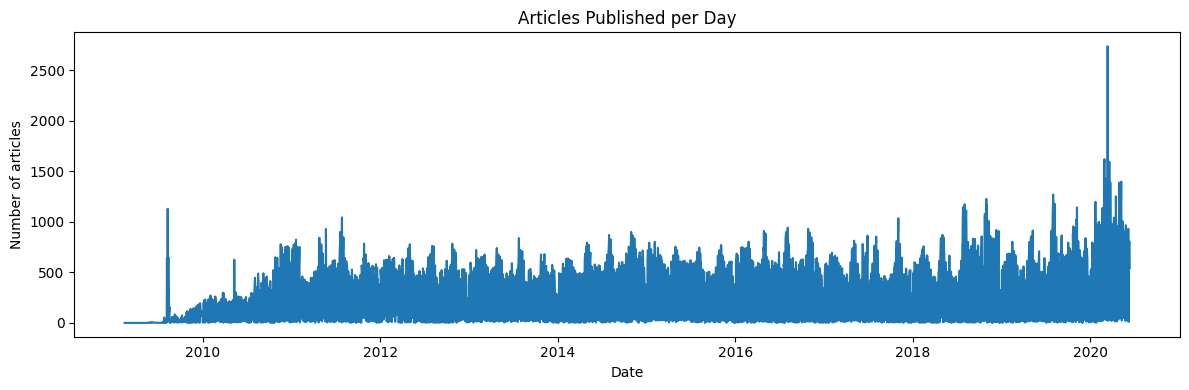

In [13]:
plt.figure(figsize=(12, 4))
articles_per_day.plot()
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Articles Published per Day")
plt.tight_layout()
plt.show()


Articles by weekday

In [14]:
weekday_counts = (
    df["weekday"]
    .value_counts()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

weekday_counts


weekday
Monday       265139
Tuesday      296505
Wednesday    300922
Thursday     302619
Friday       217918
Saturday       7759
Sunday        16466
Name: count, dtype: int64

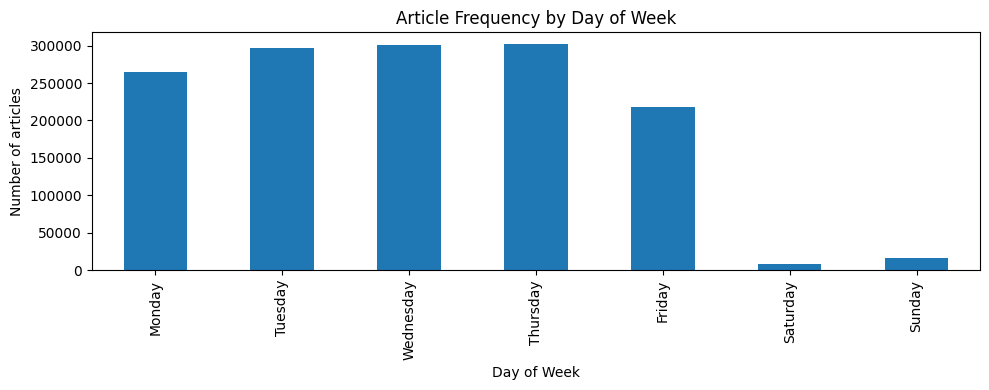

In [15]:
plt.figure()
weekday_counts.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Number of articles")
plt.title("Article Frequency by Day of Week")
plt.tight_layout()
plt.show()
